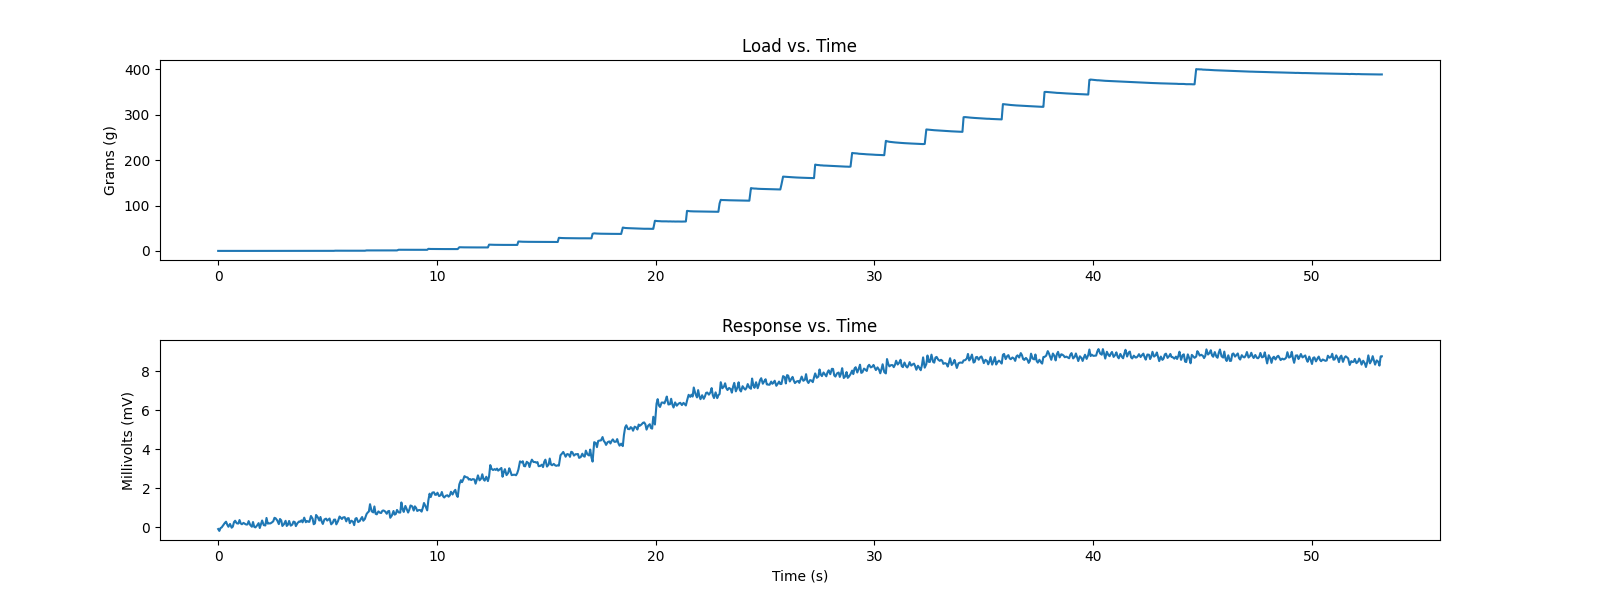

In [85]:
### Just goofin here

from operator import index
import scipy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.widgets import SpanSelector
from scipy.optimize import curve_fit
import xlsxwriter
from pathlib import Path
import os
%matplotlib widget

"""
This code is written to generate Response vs. Load graphs for PVC
gel sensors. In this experiment, there was cross-chatter between
channels when using one Keithly DAQ and this facilitated the use of two s
seperate Keithly devices which were set to tirgger at the same time. 
This resulted in two .csv files for each experiment, one for the response 
and one for the load. These two files are combined in this code 
to yield the final Response vs. Load Data
"""



##############################################################
# Input load file name, PVC file name will be automatically generated
load_filename = "LOADP4_vA_16mm"
pvc_filename = load_filename.replace("LOAD", "PVC")

# Verify folder is correct
folder = "variable_area_P4"
##############################################################


DEFAULT_DATA_DIR = Path("~/SPIE_data/").expanduser()
# final filename string 
final_file = load_filename.replace("LOAD", "")



# Default data directory
# ~ stands for the user folder: C:/Users/username
# .expanduser() ensures that the tilde ~ actually represents the user's home path


if os.path.exists(f"{DEFAULT_DATA_DIR}\{folder}") == False:
    (DEFAULT_DATA_DIR/Path(folder)).mkdir(parents=True, exist_ok = False)


load =  pd.read_csv(
    "C:/Users/asenn/OneDrive/School/Research/SPIE 2023/Data/curved_and_repeated_testing/" + folder + "/" + load_filename + ".csv",
    # Do not read row 1 (zero index) of Excel file
    skiprows=17,
    # Read cols A:C only in Excel,
    usecols=["Relative Time", 'CH110'],
    # The index (or x-axis)
)

pvc = pd.read_csv(
        "C:/Users/asenn/OneDrive/School/Research/SPIE 2023/Data/curved_and_repeated_testing/" + folder + "/" + pvc_filename + ".csv",

    # Do not read row 1 (zero index) of Excel file
    skiprows=17,
    # Read cols A:C only in Excel
    usecols=["CH119"],
    # Load time index will be used
)

Load = "CH110"
PVC = "CH119"


pvc.drop([len(pvc)-1])
# drop the last row so pvc and load have...
# ... same number of datapoints

response_vs_time_df = load.join(pvc, how='left').set_index("Relative Time")


# Interpolating dataframe and getting rid of NaN
# .sort_index() numercally sorts index and all attached data
# .bfill() fills NaN values a particular value see documentation (only one Nan value after interpolate)
response_vs_time_df = response_vs_time_df.sort_index().interpolate().bfill()

# Offsetting load column to disregard initial tension on load cell 
# Uses avgLoad for the first two seconds
timeRange = response_vs_time_df[(response_vs_time_df.index) < 2]
avgLoad = timeRange[Load].mean()
response_vs_time_df = response_vs_time_df - [avgLoad,0]

# Converting PVC from V to mV
response_vs_time_df[PVC] = response_vs_time_df[PVC] * 1000

# Converting Load from V to mv, then to grams (10mv = 250g Compression)
response_vs_time_df[Load] = response_vs_time_df[Load] * 1000 * 25

# Telling matplotlib we want two plots and specifying their output size
fig, (graph1, graph2) = plt.subplots(2, figsize=(16, 6))

# Moving the plots so they're not so close together when outputting and covering labels
plt.subplots_adjust(left=0.1, bottom=0.1, right=0.9, top=0.9, wspace=0.4, hspace=0.4)

# Plotting graphs.......
graph1.plot(response_vs_time_df[Load])
graph2.plot(response_vs_time_df[PVC])

# Labeling graphs 
graph1.set_title("Load vs. Time")
graph2.set_title("Response vs. Time")
graph1.set_ylabel("Grams (g)")
graph2.set_ylabel("Millivolts (mV)")
graph2.set_xlabel("Time (s)")


### This is a dataframe that stores the range we're interested in, 
# it is populated by the user selection from the graph and is called...
# ...in the onselect_function 
dfSnips = pd.DataFrame(columns=["xmin", "xmax"])
# This function is called everytime the SpanSelector widget is used 
def onselect_function1(min_value, max_value):
    # Populate a DataFrame dfSnip that contains the 
    # min_value and # max_value of selected ranges 
    dfSnips.loc[len(dfSnips.index)] = [min_value, max_value]
    return min_value, max_value


span1 = SpanSelector(
    graph1,
    onselect_function1,
    direction="horizontal",
    useblit=True,
    props=dict(alpha=0.5, facecolor="tab:blue"),
    interactive=True,
    drag_from_anywhere=True
)

In [86]:
"""
This for loop performs a standard operation for each "snip" from the graph 
Each snip is represented by (min_value, max_value)
'row' in for loop always initializes at 0, index is being redefined from time to...
standard 0 index 
"""
# creating final dataframe to export, also method chaining to set index
final_load_vs_voltage = pd.DataFrame(columns=["Load", "Voltage"])



# ! we're iterating over a new index starting 0: len(dfSnip)-1 in increments of 1
for snip_number in dfSnips.index:
    # Setting xmin and xmax for each iteration from dfDomain
    xmin = dfSnips["xmin"][snip_number]
    xmax = dfSnips["xmax"][snip_number]
    # Manipulating data to use for exponential fit

    # The ranges selected from the graph are now cutting down the main dataframe
    sniprange = response_vs_time_df[(response_vs_time_df.index > xmin) & (response_vs_time_df.index < xmax)]
    singlesnip = pd.DataFrame(sniprange)

    # ! Here the DataFrame.mean() returns a Pandas series object
    # ! Need to access the specific values we're interested in using .loc()
    # display(singlesnip.mean())
    # display(singlesnip.mean().loc["CH110"])

    final_load_vs_voltage.loc[snip_number] = [singlesnip.mean().loc["CH110"], singlesnip.mean().loc["CH119"]]

    # Now we need to populate a new DataFrame that will be written to a .csv ....
    # ... at a specified directory 

# Save directory to .csv on user's computer 
final_load_vs_voltage.set_index("Load").to_csv(DEFAULT_DATA_DIR / Path(f"{folder}\{final_file}.csv"))

display(final_load_vs_voltage)




 



,Load,Voltage
0,7.698189,2.478292
1,13.242764,2.844076
2,19.859972,3.263893
3,27.919123,3.715800
4,37.632930,4.417551
5,49.150705,5.178271
6,64.936553,6.392815
7,86.553117,6.816758
8,111.123268,7.135929
9,136.285663,7.398993
